In [93]:
import tensorflow
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard
from warnings import filterwarnings
filterwarnings('ignore')

In [94]:
classifier = Sequential()
classifier.add(Conv2D(32,(3,3),input_shape=(64,64,3),activation = 'relu'))
classifier.add(MaxPooling2D(pool_size=(2,2),strides=2)) #if stride not given it equal to pool filter size
classifier.add(Conv2D(32,(3,3),activation = 'relu'))
classifier.add(MaxPooling2D(pool_size=(2,2),strides=2))
classifier.add(Flatten())
classifier.add(Dense(units=128,activation='relu'))
classifier.add(Dense(units=1,activation='sigmoid'))
adam = tensorflow.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
classifier.compile(optimizer=adam,loss='binary_crossentropy',metrics=['accuracy'])
#tensorboard = TensorBoard(log_dir="logs/{}".format(time()))

In [95]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

#Training Set
train_set = train_datagen.flow_from_directory('images/train',
                                             target_size=(64,64),
                                             batch_size=32,
                                             class_mode='binary')
#Validation Set
test_set = test_datagen.flow_from_directory('images/test',
                                           target_size=(64,64),
                                           batch_size = 32,
                                           class_mode='binary',
                                           shuffle=False)
#Test Set /no output available
test_set1 = test_datagen.flow_from_directory('images/validation',
                                            target_size=(64,64),
                                            batch_size=32,
                                            shuffle=False)

Found 480 images belonging to 2 classes.
Found 120 images belonging to 2 classes.
Found 121 images belonging to 2 classes.


In [96]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [97]:
classifier.fit_generator(train_set,
                        steps_per_epoch=300, 
                        epochs = 50,
                        validation_data = test_set,
                        validation_steps = 20, 
                        #callbacks=[tensorboard]
                        );
classifier.save('tammatomaize_model_bak.h5')

Epoch 1/50
300/300 [==============================] - 3s 8ms/step - loss: 0.8012 - accuracy: 0.5031 - val_loss: 0.6375 - val_accuracy: 0.5250


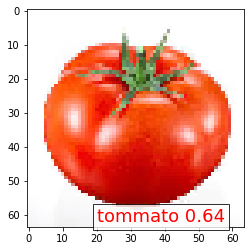

In [99]:
#Prediction of image
%matplotlib inline
import tensorflow
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
img1 = image.load_img('images/validation/tommato/20.jpg', target_size=(64, 64))
img = image.img_to_array(img1)
img = img/255
# create a batch of size 1 [N,H,W,C]
img = np.expand_dims(img, axis=0)
prediction = classifier.predict(img, batch_size=None,steps=1) #gives all class prob.
if(prediction[:,:]>0.5):
    value ='tommato %1.2f'%(prediction[0,0])
    plt.text(20, 62,value,color='red',fontsize=18,bbox=dict(facecolor='white',alpha=0.8))
else:
    value ='maize :%1.2f'%(1.0-prediction[0,0])
    plt.text(20, 62,value,color='red',fontsize=18,bbox=dict(facecolor='white',alpha=0.8))

plt.imshow(img1)
plt.show()

In [53]:
import pandas as pd
test_set.reset
ytesthat = classifier.predict_generator(test_set)
df = pd.DataFrame({
    'filename':test_set.filenames,
    'predict':ytesthat[:,0],
    'y':test_set.classes
})

In [54]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)
df['y_pred'] = df['predict']>0.5
df.y_pred = df.y_pred.astype(int)
df.head(10)

,filename,predict,y,y_pred
0,maize\0.jpg,0.50622,0,1
1,maize\1.jpg,0.52690,0,1
2,maize\10.jpg,0.49882,0,0
3,maize\11.jpg,0.51682,0,1
4,maize\12.jpg,0.50061,0,1
5,maize\13.jpg,0.49609,0,0
6,maize\14.jpg,0.49492,0,0
7,maize\15.jpg,0.49735,0,0
8,maize\16.jpg,0.50023,0,1
9,maize\17.jpg,0.50641,0,1


In [55]:
misclassified = df[df['y']!=df['y_pred']]
print('Total misclassified image from 5000 Validation images : %d'%misclassified['y'].count())

Total misclassified image from 5000 Validation images : 64


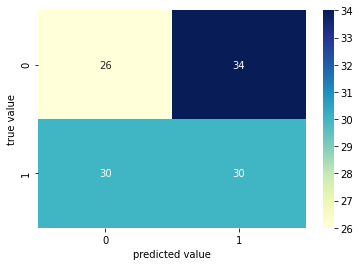

In [56]:
from sklearn.metrics import confusion_matrix 
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = confusion_matrix(df.y,df.y_pred)
sns.heatmap(conf_matrix,cmap="YlGnBu",annot=True,fmt='g');
plt.xlabel('predicted value')
plt.ylabel('true value');

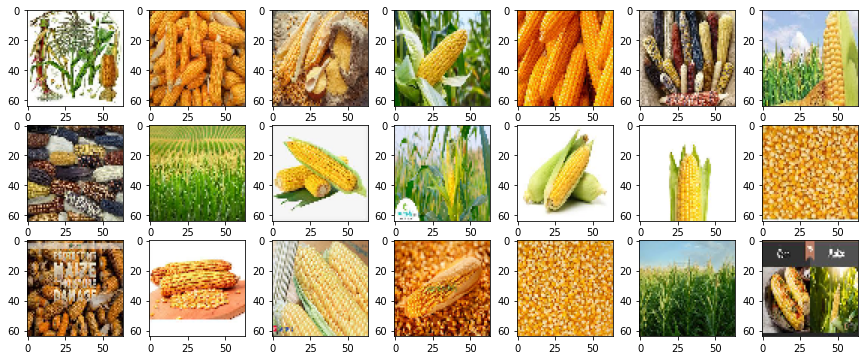

In [59]:
#some maize missclassified as tommato
import matplotlib.image as mpimg

maizeTommato = df['filename'][(df.y==0)&(df.y_pred==1)]
fig=plt.figure(figsize=(15, 6))
columns = 7
rows = 3
for i in range(columns*rows):
    #img = mpimg.imread()
    img = image.load_img('images/test/'+maizeTommato.iloc[i], target_size=(64, 64))
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)

plt.show()

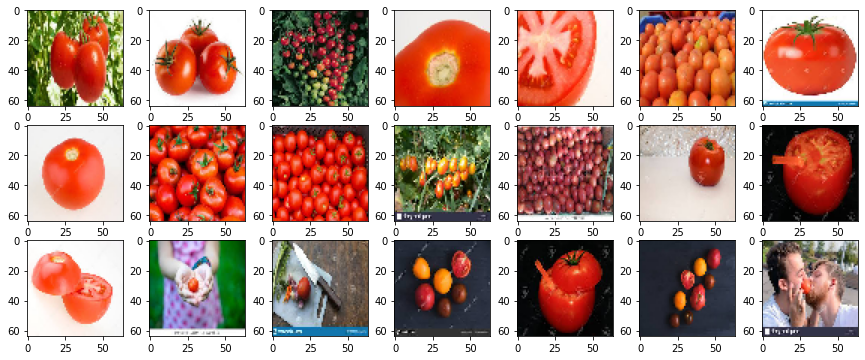

In [61]:
#Some of tommato image misclassified as maize.
import matplotlib.image as mpimg

tommatoMaize = df['filename'][(df.y==1)&(df.y_pred==0)]
fig=plt.figure(figsize=(15, 6))
columns = 7
rows = 3
for i in range(columns*rows):
    #img = mpimg.imread()
    img = image.load_img('images/test/'+tommatoMaize.iloc[i], target_size=(64, 64))
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)
plt.show()

In [62]:
classifier.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 128)               802944    
_________________________________________________________________
dense_15 (Dense)             (None, 1)                

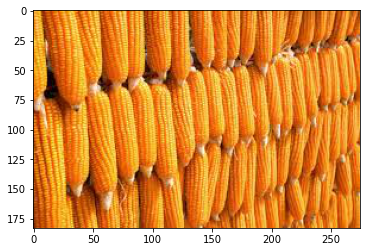

In [64]:
#Input Image for Layer visualization
img1 = image.load_img('images/test/maize/14.jpg')
plt.imshow(img1);
#preprocess image
img1 = image.load_img('images/test/maize/14.jpg', target_size=(64, 64))
img = image.img_to_array(img1)
img = img/255
img = np.expand_dims(img, axis=0)

In [69]:
model_layers = [ layer.name for layer in classifier.layers]
print('layer name : ',model_layers)
from tensorflow.keras.models import Model
conv2d_15_output = Model(inputs=classifier.input, outputs=classifier.get_layer('conv2d_15').output)
conv2d_14_output = Model(inputs=classifier.input,outputs=classifier.get_layer('conv2d_14').output)
conv2d_15_features = conv2d_15_output.predict(img)
conv2d_14_features = conv2d_14_output.predict(img)
print('First conv layer feature output shape : ',conv2d_14_features.shape)
print('First conv layer feature output shape : ',conv2d_15_features.shape)

layer name :  ['conv2d_14', 'max_pooling2d_14', 'conv2d_15', 'max_pooling2d_15', 'flatten_7', 'dense_14', 'dense_15']
First conv layer feature output shape :  (1, 62, 62, 32)
First conv layer feature output shape :  (1, 29, 29, 32)


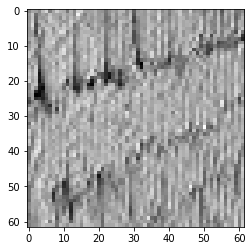

In [70]:
#filterimage
plt.imshow(conv2d_14_features[0, :, :, 4], cmap='gray')

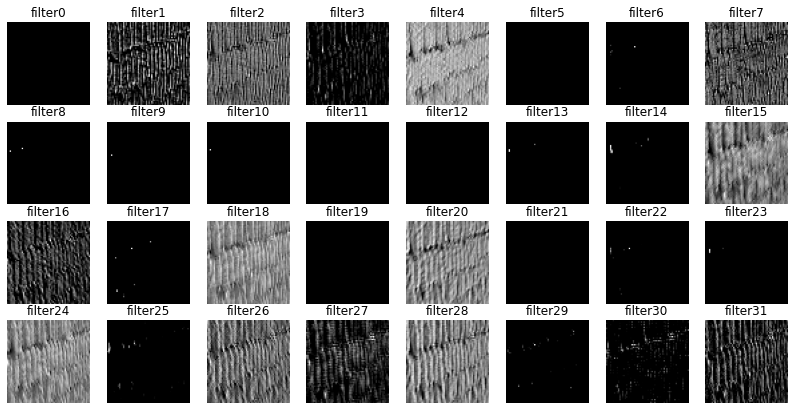

In [72]:
#First Covolution Layer Output
import matplotlib.image as mpimg

fig=plt.figure(figsize=(14,7))
columns = 8
rows = 4
for i in range(columns*rows):
    #img = mpimg.imread()
    fig.add_subplot(rows, columns, i+1)
    plt.axis('off')
    plt.title('filter'+str(i))
    plt.imshow(conv2d_14_features[0, :, :, i], cmap='gray')
plt.show()

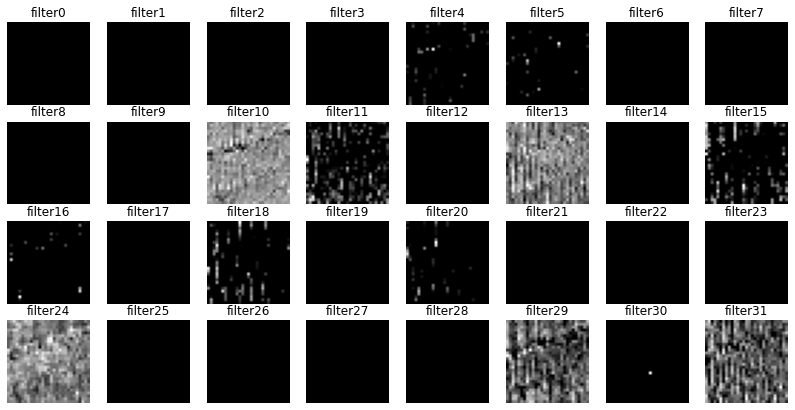

In [75]:
#Second Covolution Layer Output
fig=plt.figure(figsize=(14,7))
columns = 8
rows = 4
for i in range(columns*rows):
    #img = mpimg.imread()
    fig.add_subplot(rows, columns, i+1)
    plt.axis('off')
    plt.title('filter'+str(i))
    plt.imshow(conv2d_15_features[0, :, :, i], cmap='gray')
plt.show()


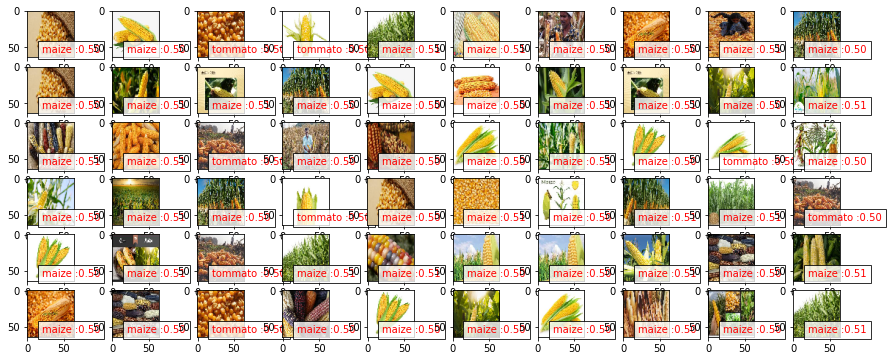

In [82]:
#Model Performance on Unseen Data
# ypred = classifier.predict_generator(test_set)

fig=plt.figure(figsize=(15, 6))
columns = 10
rows = 6
for i in range(columns*rows):
    fig.add_subplot(rows, columns, i+1)
    img1 = image.load_img('images/validation/'+test_set1.filenames[np.random.choice(range(60))], target_size=(64, 64))
    img = image.img_to_array(img1)
    img = img/255
    img = np.expand_dims(img, axis=0)
    prediction = classifier.predict(img, batch_size=None,steps=1) #gives all class prob.
    if(prediction[:,:]>0.5):
        value ='tommato :%1.2f'%(prediction[0,0])
        plt.text(20, 58,value,color='red',fontsize=10,bbox=dict(facecolor='white',alpha=0.8))
    else:
        value ='maize :%1.2f'%(1.0-prediction[0,0])
        plt.text(20, 58,value,color='red',fontsize=10,bbox=dict(facecolor='white',alpha=0.8))
    plt.imshow(img1)

In [83]:
# Model Accuracy
x1 = classifier.evaluate_generator(train_set)
x2 = classifier.evaluate_generator(test_set)
print('Training Accuracy  : %1.2f%%     Training loss  : %1.6f'%(x1[1]*100,x1[0]))
print('Validation Accuracy: %1.2f%%     Validation loss: %1.6f'%(x2[1]*100,x2[0]))

Training Accuracy  : 50.00%     Training loss  : 0.693297
Validation Accuracy: 50.00%     Validation loss: 0.693447


In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
def build_classifier(optimizer):
    classifier = Sequential()
    classifier.add(Conv2D(32,(3,3),input_shape=(64,64,3),activation = 'relu'))
    classifier.add(MaxPooling2D(pool_size=(2,2),strides=2)) #if stride not given it equal to pool filter size
    classifier.add(Conv2D(32,(3,3),activation = 'relu'))
    classifier.add(MaxPooling2D(pool_size=(2,2),strides=2))
    classifier.add(Flatten())
    classifier.add(Dense(units=128,activation='relu'))
    classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return classifier
classifier = KerasClassifier(build_fn = build_classifier)
parameters = {'batch_size': [25, 32],
              'epochs': [100, 500],
              'optimizer': ['adam', 'rmsprop']}
grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10)
grid_search = grid_search.fit(train_set,test_set)#train and test
best_parameters = grid_search.best_params_
best_accuracy = grid_search.best_score_